<a href="https://colab.research.google.com/github/FyodorAmanov1/WeatherPrediction/blob/main/ProjectNumMeth1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade meteostat
!pip install numpy
!pip install pandas

from datetime import datetime
from meteostat import Point, Hourly
from meteostat import Point, Daily
import numpy as np
import pandas as pd

In [23]:
!pip install astral

In [25]:
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime, timedelta

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
def S(x, beta, D, t_sunrise):
  return beta*max(0, math.sin(2*math.pi*(x - t_sunrise)/D*60))

def T_target(x, T_monthly_mean, Tmonthly_minimum, T_monthly_max, month, t_peak):
  return T_monthly_mean[month] + (T_monthly_max[month] - Tmonthly_minimum[month])/2*math.sin(2*math.pi*(x - t_peak)/1440)

def T_pattern(x, T_prev_minute_temps, T_monthly_mean, month):
  return T_prev_minute_temps[x] + T_monthly_mean[month] - np.mean(T_prev_minute_temps)

def TemperatureModel(x, T, data):
  alpha1, alpha2, beta, dayLength, t_sunrise, T_monthly_mean, Tmonthly_minimum, T_monthly_max, T_prev, month, t_peak = data
  if x - math.floor(x) == 0.5:
    return (TemperatureModel(int(x - 0.5), T, data) + TemperatureModel(int(x + 0.5), T, data))/2
  else:
    return alpha1*(T_target(x, T_monthly_mean, Tmonthly_minimum, T_monthly_max, month, t_peak) - T) + alpha2*(T_pattern(x, T_prev, T_monthly_mean, month) - T) + S(x, beta, dayLength, t_sunrise)

In [5]:
def DERunge_Kutta_4(func, T0, time0, data):

  N = 1440
  time = [time0 + i for i in range(N)]
  T = [0 for i in range(N)]
  T[0] = T0

  alpha1, alpha2, beta, dayLength, t_sunrise, T_monthly_mean, T_monthly_min, T_monthly_max, T_prev, month, t_peak = data

  for i in range(1, N - 1):
    k1 = func(time0 + i, T[i], data)

    k2 = func(time0 + i + 1/2, T[i] + k1/2, data)

    k3 = func(time0 + i + 1/2, T[i] + k2/2, data)

    k4 = func(time0 + i + 1, T[i] + k3, data)

    T[i+1] = T[i] + (k1 + 2*k2 + 2*k3 + k4)/6


  T_monthly_mean_repeated = np.repeat(T_monthly_mean[month], len(time))
  T_monthly_min_repeated = np.repeat(T_monthly_min[month], len(time))
  T_monthly_max_repeated = np.repeat(T_monthly_max[month], len(time))

  plt.plot(time, T, label="Predicted")
  plt.plot(time, T_monthly_mean_repeated, label="Monthly mean")  # Use repeated values
  plt.plot(time, T_monthly_min_repeated, label="Monthly min")  # Use repeated values
  plt.plot(time, T_monthly_max_repeated, label="Monthly max")  # Use repeated values
  plt.plot(time, T_prev, label="Previous day temperature")

  plt.legend()

  plt.title('Temperature Model')
  plt.xlabel('Time')
  plt.ylabel('Temperature')
  plt.show()


In [6]:
print("Enter year, month and day: ")
year = int(input())
month = int(input())
day = int(input())

Enter year, month and day: 
2005
11
1


In [42]:
print("Enter city name: ")
city_name = input()

Enter city name: 
London Uk


In [43]:
from astral import LocationInfo
from astral.sun import sun
from datetime import datetime
from geopy.geocoders import Nominatim

# Function to get city coordinates using geopy
def get_city_coordinates(city_name: str):
    geolocator = Nominatim(user_agent="city_locator")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        raise ValueError(f"Could not find coordinates for {city_name}")

try:
    latitude, longitude = get_city_coordinates(city_name)
    print(f"Latitude: {latitude}, Longitude: {longitude}")
    location = Point(latitude, longitude)
except Exception as e:
    print(e)


Latitude: 51.4893335, Longitude: -0.14405508452768728


In [44]:
start = datetime(year, 1, 1)
end = datetime(year, 12, 31)

In [45]:
try:
    data = Daily(location, start, end)
    data = data.fetch()
    print("Data fetched successfully!")

    # Check if the DataFrame is empty
    if data.empty:
        print("No data found for the specified location and date range.")
        # Proceed with generating synthetic data using estimated values
    else:
        # Access temperature columns and handle missing values
        tavg = data['tavg'].fillna(method='ffill').values
        tmin = data['tmin'].fillna(method='ffill').values
        tmax = data['tmax'].fillna(method='ffill').values

        # Calculate monthly statistics
        T_monthly_mean = []
        T_monthly_min = []
        T_monthly_max = []

        for month in range(1, 13):
            monthly_data_tavg = tavg[(data.index.month == month)]
            monthly_data_tmin = tmin[(data.index.month == month)]
            monthly_data_tmax = tmax[(data.index.month == month)]

            if len(monthly_data_tavg) > 0:
                T_monthly_mean.append(np.mean(monthly_data_tavg))
                T_monthly_min.append(np.min(monthly_data_tmin))
                T_monthly_max.append(np.max(monthly_data_tmax))
            else:
                # Handle missing data using estimated values
                T_monthly_mean.append(np.nan)
                T_monthly_min.append(np.nan)
                T_monthly_max.append(np.nan)


        T_monthly_mean = np.nan_to_num(T_monthly_mean, nan=15)  # Example: Replace NaN with 15
        T_monthly_min = np.nan_to_num(T_monthly_min, nan=5)      # Example: Replace NaN with 5
        T_monthly_max = np.nan_to_num(T_monthly_max, nan=25)     # Example: Replace NaN with 25

        print("Monthly Mean Temperatures:", T_monthly_mean)
        print("Monthly Minimum Temperatures:", T_monthly_min)
        print("Monthly Maximum Temperatures:", T_monthly_max)

except Exception as e:
    print(f"Error fetching data: {e}")
    # Proceed with generating synthetic data using estimated values

Data fetched successfully!
Monthly Mean Temperatures: [ 7.73870968  5.52857143  8.58064516 11.03333333 13.42580645 17.91
 18.43870968 18.29677419 17.21       14.91612903  8.01666667  6.22903226]
Monthly Minimum Temperatures: [ 0.9 -1.6 -0.7  0.8  5.   7.4 11.6 11.4  4.9  8.9  0.3 -0.9]
Monthly Maximum Temperatures: [14.2 13.2 20.3 23.  31.7 33.1 30.7 31.9 28.1 22.9 18.  12.2]


In [46]:
# Date for which you want hourly data
if day == 1 and month == 1:
  year = year - 1
  month = 12
  day = 30
elif day == 1:
  month = month - 1
  if year % 4 == 0:
    v = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    day = v[month - 1] - 1
  else:
    v = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    day = v[month - 1] - 1
else:
  day = day - 1
target_date = datetime(year, month, day)  # Change year if needed

# Get hourly data for the target date
start = datetime(target_date.year, target_date.month, target_date.day, 0, 0)
end = datetime(target_date.year, target_date.month, target_date.day, 23, 59)

try:
    data = Hourly(location, start, end)
    data = data.fetch()
    print("Hourly data fetched successfully!")

    # Check if the DataFrame is empty
    if data.empty:
        print("No hourly data found for the specified location and date range.")
        # Handle case where no data is found (e.g., use estimated values)
    else:
        # Reset index to avoid potential future issues
        data = data.reset_index()

        T_prev = np.array(data['temp'])

except Exception as e:
    print(f"Error fetching data: {e}")
    # Handle error (e.g., use estimated values)

Hourly data fetched successfully!


In [47]:
import numpy as np

def interpolate_temperatures(hourly_temperatures):
  """
  Interpolates hourly temperatures to minute-level temperatures.

  Args:
    hourly_temperatures: A list or array of 24 hourly temperature values.

  Returns:
    An array of 1440 minute-level temperatures.
  """
  minutes_in_hour = 60
  total_minutes = 24 * minutes_in_hour  # 1440 minutes in a day

  # Create an array of minutes (0 to 1439)
  minutes = np.arange(total_minutes)

  # Create an array of hours (0 to 23)
  hours = np.arange(24)

  # Interpolate hourly temperatures to minute-level temperatures
  minute_temperatures = np.interp(minutes, hours * minutes_in_hour, hourly_temperatures)

  return minute_temperatures


T_prev_minute_temps = interpolate_temperatures(T_prev)

print(T_prev)
print(*T_prev_minute_temps)  # Output: 1440

[1.8 1.4 1.3 1.  1.  0.9 0.9 0.8 0.9 1.  0.9 1.3 1.9 1.9 2.2 1.8 1.7 1.3
 1.6 1.7 1.7 1.3 0.9 0.9]
1.8 1.7933333333333334 1.7866666666666666 1.78 1.7733333333333334 1.7666666666666666 1.76 1.7533333333333334 1.7466666666666666 1.74 1.7333333333333334 1.7266666666666666 1.72 1.7133333333333334 1.7066666666666668 1.7 1.6933333333333334 1.6866666666666668 1.68 1.6733333333333333 1.6666666666666667 1.66 1.6533333333333333 1.6466666666666667 1.64 1.6333333333333333 1.6266666666666667 1.62 1.6133333333333333 1.6066666666666667 1.6 1.5933333333333333 1.5866666666666667 1.58 1.5733333333333333 1.5666666666666667 1.56 1.5533333333333332 1.5466666666666666 1.54 1.5333333333333332 1.5266666666666666 1.52 1.5133333333333332 1.5066666666666666 1.5 1.4933333333333332 1.4866666666666666 1.48 1.4733333333333332 1.4666666666666666 1.46 1.4533333333333331 1.4466666666666665 1.44 1.4333333333333331 1.4266666666666665 1.42 1.4133333333333333 1.4066666666666665 1.4 1.3983333333333332 1.3966666666666665 1.3

In [48]:
from astral import LocationInfo
from astral.sun import sun

# Define city information using LocationInfo
city = LocationInfo(city_name, region, timezone, latitude, longitude)


In [49]:
s = sun(city.observer, date=target_date)

# Get sunrise time in minutes since midnight
sunrise_time = s['sunrise']
t_sunrise = int((sunrise_time - sunrise_time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds() / 60)

print(t_sunrise)

486


In [50]:
dusk_time = s['dusk']
dusk_minutes = int((dusk_time - dusk_time.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds() / 60)

In [51]:
alpha1 = 0.1
alpha2 = 1
beta = 1
dayLength = 12

In [52]:
t_peak = 14*60
month = month - 1

data = [alpha1, alpha2, beta, dayLength, t_sunrise, T_monthly_mean, T_monthly_min, T_monthly_max, T_prev_minute_temps, month, t_peak]

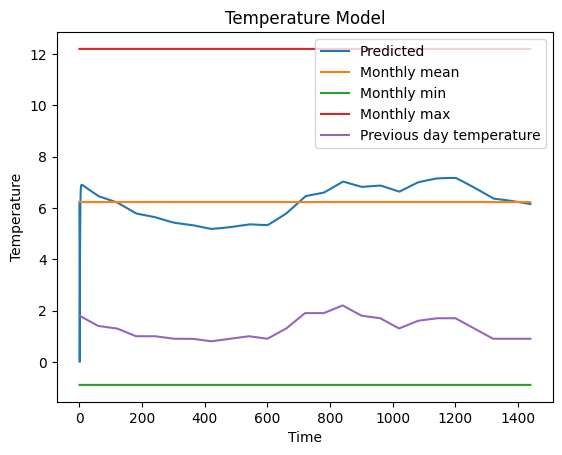

In [53]:
DERunge_Kutta_4(TemperatureModel, T_monthly_mean[month], 0, data)